# Experiments - Physics-SR Framework v3.0 Benchmark

## Benchmark Experiment Execution Module

**Author:** Zhengze Zhang  
**Affiliation:** Department of Statistics, Columbia University  
**Date:** January 2026

---

### Purpose

This notebook executes all benchmark experiments for the Physics-SR Framework v3.0:

1. **Method Runners**: Wrappers for Physics-SR, PySR-Only, and LASSO+PySR
2. **Evaluation Functions**: Variable selection, equation recovery, prediction metrics
3. **Experiment Runner**: Orchestrates all experiments with checkpointing
4. **Results Collection**: Saves to CSV and PKL formats

### Experimental Design

**Core Experiments (96 runs):**
- 4 equations x 2 noise (0%, 5%) x 2 dummy (0, 5) x 2 dims (T/F) x 3 methods = 96

**Supplementary Experiments (8 runs):**
- 4 equations x 2 sample sizes (250, 750) x Physics-SR only = 8

### Methods Compared

| Method | Description |
|--------|-------------|
| Physics-SR | Full 3-stage framework with physics knowledge |
| PySR-Only | Genetic programming baseline (no preprocessing) |
| LASSO+PySR | LASSO feature selection + PySR on selected features |

---
## Section 1: Header and Imports

In [242]:
# ==============================================================================
# ENVIRONMENT RESET AND FRESH CLONE
# ==============================================================================

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    import os
    import shutil
    import gc

    # CRITICAL: Change to /content FIRST
    try:
        os.chdir('/content')
    except:
        pass

    # Clear memory
    gc.collect()

    # Remove existing repository if present
    repo_path = '/content/Physics-Informed-Symbolic-Regression'
    if os.path.exists(repo_path):
        shutil.rmtree(repo_path)
        print("[OK] Removed existing repository.")

    # Clone fresh repository
    !git clone https://github.com/Garthzzz/Physics-Informed-Symbolic-Regression.git

    # Verify clone succeeded
    if os.path.exists(repo_path):
        print("[OK] Fresh repository cloned.")

        # Change to benchmark directory
        os.chdir(repo_path + '/benchmark')
        print(f"[OK] Working directory: {os.getcwd()}")

        # Verify
        !git log --oneline -3
    else:
        print("[FAIL] Clone failed!")

    print()
    print("[OK] Environment reset complete.")
else:
    print("[INFO] Not in Colab environment.")

[OK] Removed existing repository.
Cloning into 'Physics-Informed-Symbolic-Regression'...
remote: Enumerating objects: 181, done.
remote: Counting objects: 100% (181/181), done.
remote: Compressing objects: 100% (119/119), done.
Receiving objects: 100% (181/181), 1.31 MiB | 18.42 MiB/s, done.
remote: Total 181 (delta 103), reused 136 (delta 60), pack-reused 0 (from 0)
Resolving deltas: 100% (103/103), done.
[OK] Fresh repository cloned.
[OK] Working directory: /content/Physics-Informed-Symbolic-Regression/benchmark
975bee2 (HEAD -> main, origin/main, origin/HEAD) fix
d9d89d6 update
6e0dbd2 update

[OK] Environment reset complete.


In [243]:
# ==============================================================================
# COLAB SETUP - Run this cell first!
# ==============================================================================
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    import os
    if not os.path.exists('/content/Physics-Informed-Symbolic-Regression'):
        !git clone https://github.com/Garthzzz/Physics-Informed-Symbolic-Regression.git
        print("Repository cloned!")

    %cd /content/Physics-Informed-Symbolic-Regression

    # Install PySR
    !pip install -q pysr
    import pysr
    pysr.install()

    # Verify data files
    from pathlib import Path
    data_files = list(Path('benchmark/data').glob('*.npz'))
    print(f"\nFound {len(data_files)} data files")

    if len(data_files) == 24:
        print("[OK] All data files present!")
    else:
        print("[WARNING] Expected 24 files")

    print("\nSetup complete!")

/content/Physics-Informed-Symbolic-Regression

Found 24 data files
[OK] All data files present!

Setup complete!


In [244]:
"""
Experiments.ipynb - Benchmark Experiment Execution Module
==========================================================

Physics-SR Framework v3.0 Benchmark Suite

This module provides:
- Method runners for Physics-SR, PySR-Only, LASSO+PySR
- Evaluation functions for variable selection and prediction
- Experiment orchestration with checkpointing
- Results collection and storage

Author: Zhengze Zhang
Affiliation: Department of Statistics, Columbia University
"""

# Standard library imports
import os
import sys
import time
import pickle
import warnings
from datetime import datetime
from pathlib import Path
from typing import Dict, List, Tuple, Optional, Any, Union
from dataclasses import dataclass, field, asdict

# Scientific computing
import numpy as np
import pandas as pd
from scipy import stats

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV, Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Progress bar
try:
    from tqdm.notebook import tqdm
except ImportError:
    from tqdm import tqdm

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

print("Experiments: All imports successful.")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

Experiments: All imports successful.
NumPy version: 2.0.2
Pandas version: 2.2.2


In [245]:
# ==============================================================================
# PATH CONFIGURATION
# ==============================================================================

# Determine paths based on environment
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # Colab paths
    BASE_DIR = Path('/content/Physics-Informed-Symbolic-Regression')
    ALGORITHMS_DIR = BASE_DIR / 'algorithms'
    BENCHMARK_DIR = BASE_DIR / 'benchmark'
else:
    # Local paths
    BENCHMARK_DIR = Path('.').resolve()
    ALGORITHMS_DIR = BENCHMARK_DIR.parent / 'algorithms'
    BASE_DIR = BENCHMARK_DIR.parent

DATA_DIR = BENCHMARK_DIR / 'data'
RESULTS_DIR = BENCHMARK_DIR / 'results'

# Create directories if needed
DATA_DIR.mkdir(exist_ok=True, parents=True)
RESULTS_DIR.mkdir(exist_ok=True, parents=True)

print(f"Environment: {'Google Colab' if IN_COLAB else 'Local'}")
print(f"Base directory: {BASE_DIR}")
print(f"Algorithms directory: {ALGORITHMS_DIR}")
print(f"Benchmark directory: {BENCHMARK_DIR}")
print(f"Data directory: {DATA_DIR}")
print(f"Results directory: {RESULTS_DIR}")

# Verify data files
data_files = list(DATA_DIR.glob('*.npz'))
print(f"Found {len(data_files)} data files")

Environment: Google Colab
Base directory: /content/Physics-Informed-Symbolic-Regression
Algorithms directory: /content/Physics-Informed-Symbolic-Regression/algorithms
Benchmark directory: /content/Physics-Informed-Symbolic-Regression/benchmark
Data directory: /content/Physics-Informed-Symbolic-Regression/benchmark/data
Results directory: /content/Physics-Informed-Symbolic-Regression/benchmark/results
Found 24 data files


In [246]:
# ==============================================================================
# IMPORT ALGORITHM MODULES
# ==============================================================================

print("Loading algorithm modules...")
print()

# Change to algorithms directory for relative imports
original_dir = os.getcwd()
os.chdir(ALGORITHMS_DIR)

# Import all algorithm notebooks
%run 00_Core.ipynb
%run 01_BuckinghamPi.ipynb
%run 02_VariableScreening.ipynb
%run 03_SymmetryAnalysis.ipynb
%run 04_InteractionDiscovery.ipynb
%run 05_FeatureLibrary.ipynb
%run 06_PySR.ipynb
%run 07_EWSINDy_STLSQ.ipynb
%run 08_AdaptiveLasso.ipynb
%run 09_ModelSelection.ipynb
%run 10_PhysicsVerification.ipynb
%run 11_UQ_Inference.ipynb
%run 12_Full_Pipeline.ipynb

# Change back to benchmark directory
os.chdir(original_dir)

print()
print("=" * 70)
print(" All algorithm modules loaded successfully!")
print("=" * 70)

Loading algorithm modules...

00_Core: All imports successful.
NumPy version: 2.0.2
Pandas version: 2.2.2
Global configuration constants defined.
UserInputs dataclass defined.
Stage1Results dataclass defined.
Stage2Results dataclass defined.
Stage3Results dataclass defined.
Numerical safety functions defined.
Metric functions defined.
Formatting functions defined.
Data preprocessing functions defined.
Warm rain data generator defined.
Polynomial data generator defined.
Trigonometric data generator defined.
Pendulum data generator defined.
 00_Core.ipynb - Module Summary

DATACLASSES:
  - UserInputs: User-defined inputs (dimensions, bounds, mappings)
  - Stage1Results: Variable selection & preprocessing results
  - Stage2Results: Structure discovery results
  - Stage3Results: Validation & UQ results

UTILITY FUNCTIONS:
  - safe_log, safe_divide, safe_power: Numerical safety
  - compute_r2, compute_mse, compute_rmse, compute_mae: Metrics
  - format_equation: Equation string formatting
  

Loading DataGen utilities...
/content/Physics-Informed-Symbolic-Regression/benchmark
[SKIP] Already in valid repository.
DataGen: Initializing benchmark data generation module...

DataGen: All imports successful.
NumPy version: 2.0.2
Pandas version: 2.2.2
Configuration constants defined.
  Environment: Google Colab
  Data directory: /content/Physics-Informed-Symbolic-Regression/benchmark/data
  Random seed: 42
  Sample sizes: [250, 500, 750]
  Noise levels: [0.0, 0.05]
  Dummy counts: [0, 5]
UserInputs dataclass defined.
BaseTestEquation class defined.
CoulombEquation class defined.
NewtonGravityEquation class defined.
IdealGasEquation class defined.
DampedOscillationEquation class defined.
Equation registry defined.
Available equations: ['coulomb', 'newton', 'ideal_gas', 'damped']
Experiment configuration functions defined.
  Core configs: 32
  Supplementary configs: 8
BenchmarkDataGenerator class defined.
 GENERATING CORE EXPERIMENT DATASETS

BenchmarkDataGenerator initialized.
  Out

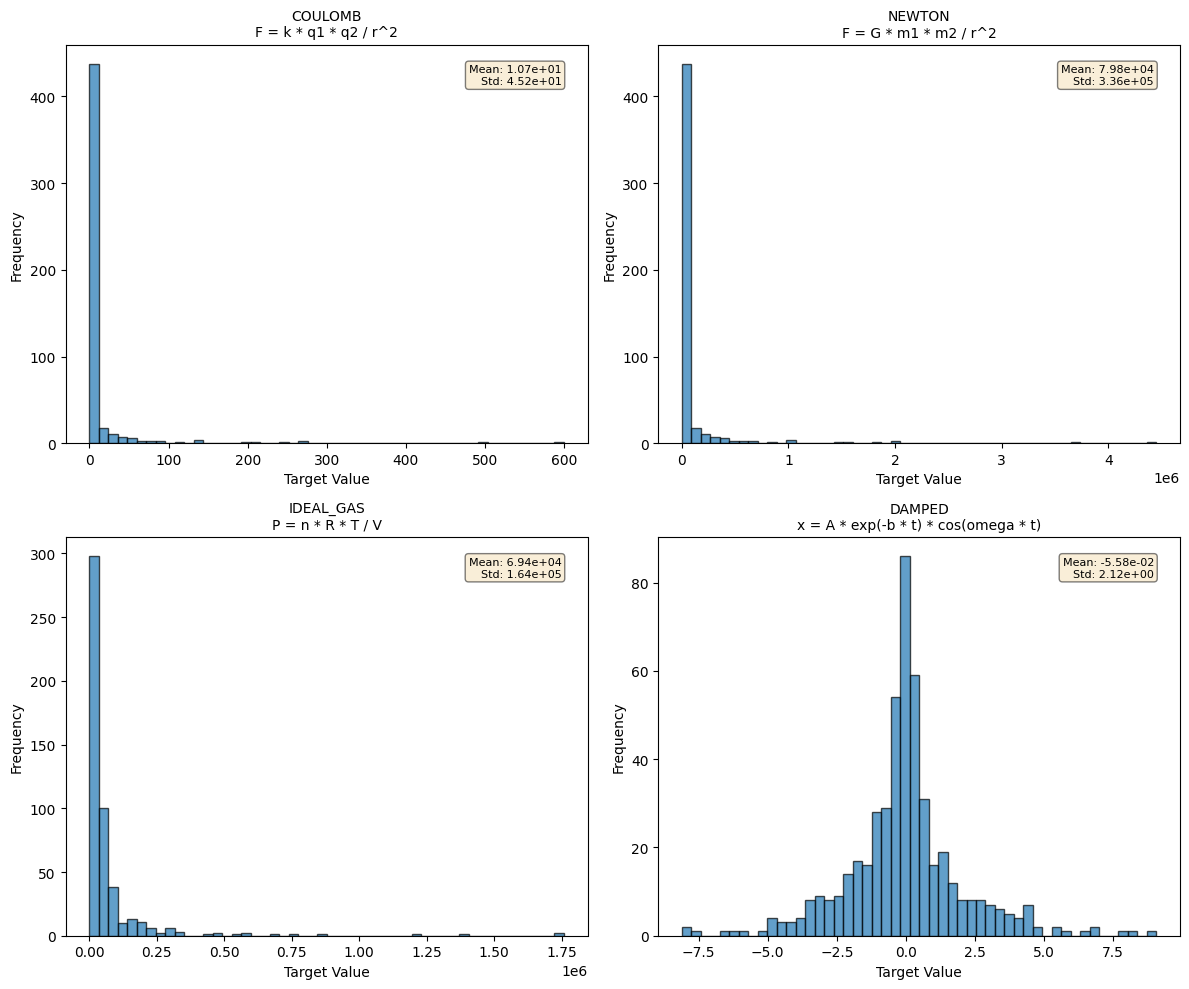


Distribution plot saved to: /content/Physics-Informed-Symbolic-Regression/benchmark/data/target_distributions.png
 DATASET SUMMARY
Output directory: /content/Physics-Informed-Symbolic-Regression/benchmark/data
Total datasets: 24

  coulomb: 6 datasets
  newton: 6 datasets
  ideal: 6 datasets
  damped: 6 datasets
 EXAMPLE: Loading Dataset for Experiments

Loaded: eq1_coulomb_n500_noise0.05_dummy5.npz

Data structure:
  X.shape = (500, 8)
  y.shape = (500,)
  feature_names = [np.str_('q1'), np.str_('q2'), np.str_('r'), np.str_('v1'), np.str_('v2'), np.str_('T'), np.str_('m'), np.str_('epsilon')]
  true_features = [np.str_('q1'), np.str_('q2'), np.str_('r')]
  dummy_features = [np.str_('v1'), np.str_('v2'), np.str_('T'), np.str_('m'), np.str_('epsilon')]

Ground truth:
  equation = F = k * q1 * q2 / r^2
  type = rational

 DataGen Module Complete

Available classes:
  - UserInputs
  - BaseTestEquation
  - CoulombEquation
  - NewtonGravityEquation
  - IdealGasEquation
  - DampedOscillatio

In [247]:
# ==============================================================================
# IMPORT DATA GENERATION UTILITIES
# ==============================================================================

print("Loading DataGen utilities...")

# Change to benchmark directory and run DataGen
%cd {BENCHMARK_DIR}
%run DataGen.ipynb

print()
print("DataGen utilities loaded.")
print(f"Available equations: {list(EQUATION_REGISTRY.keys())}")

In [248]:
# ==============================================================================
# DEBUG: CHECK FILESYSTEM BEFORE
# ==============================================================================
import os
from pathlib import Path

print("=== FILESYSTEM CHECK ===")
print(f"CWD: {os.getcwd()}")

repo = Path('/content/Physics-Informed-Symbolic-Regression')
if repo.exists():
    print(f"Repo exists: True")
    print(f"benchmark contents: {list((repo / 'benchmark').iterdir())}")
else:
    print("Repo exists: False")

=== FILESYSTEM CHECK ===
CWD: /content/Physics-Informed-Symbolic-Regression/benchmark
Repo exists: True
benchmark contents: [PosixPath('/content/Physics-Informed-Symbolic-Regression/benchmark/results'), PosixPath('/content/Physics-Informed-Symbolic-Regression/benchmark/Experiments.ipynb'), PosixPath('/content/Physics-Informed-Symbolic-Regression/benchmark/Analysis.ipynb'), PosixPath('/content/Physics-Informed-Symbolic-Regression/benchmark/DataGen.ipynb'), PosixPath('/content/Physics-Informed-Symbolic-Regression/benchmark/data')]


In [249]:
# ==============================================================================
# EXPERIMENT CONFIGURATION CONSTANTS
# ==============================================================================

# Random seed for reproducibility
EXPERIMENT_SEED = 42

# Train/test split ratio
TEST_SIZE = 0.2

# Methods to compare
METHODS = ['physics_sr', 'pysr_only', 'lasso_pysr']

# PySR configuration (reduced for faster benchmarking)
PYSR_CONFIG = {
    'niterations': 40,
    'maxsize': 20,
    'timeout_in_seconds': 90,
    'populations': 15,
}

# Physics-SR pipeline configuration
PHYSICS_SR_CONFIG = {
    'screening_threshold': 0.8,
    'power_law_r2_threshold': 0.9,
    'interaction_stability': 0.5,
    'max_poly_degree': 3,
    'stlsq_threshold': 0.1,
    'pysr_maxsize': PYSR_CONFIG['maxsize'],
    'pysr_niterations': PYSR_CONFIG['niterations'],
    'cv_folds': 5,
    'ebic_gamma': 0.5,
    'n_bootstrap': 50,
    'confidence_level': 0.95
}

# LASSO configuration
LASSO_CONFIG = {
    'cv': 5,
    'max_iter': 10000,
}

print("Experiment configuration loaded.")
print(f"Methods: {METHODS}")
print(f"Test size: {TEST_SIZE}")
print(f"Random seed: {EXPERIMENT_SEED}")

Experiment configuration loaded.
Methods: ['physics_sr', 'pysr_only', 'lasso_pysr']
Test size: 0.2
Random seed: 42


---
## Section 2: Method Runners

In [250]:
# ==============================================================================
# METHOD RESULT DATACLASS
# ==============================================================================

@dataclass
class MethodResult:
    """
    Standardized result container for all method runners.

    Attributes
    ----------
    method_name : str
        Name of the method
    discovered_features : List[str]
        Features selected/used by the method
    equation : str
        Discovered equation (string representation)
    predictions : np.ndarray
        Predictions on training data
    runtime_seconds : float
        Total runtime in seconds
    success : bool
        Whether the method completed successfully
    error_message : Optional[str]
        Error message if method failed
    method_specific : Dict
        Additional method-specific results
    """
    method_name: str
    discovered_features: List[str]
    equation: str
    predictions: np.ndarray
    runtime_seconds: float
    success: bool
    error_message: Optional[str] = None
    method_specific: Dict = field(default_factory=dict)


print("MethodResult dataclass defined.")

MethodResult dataclass defined.


In [251]:
# ==============================================================================
# PHYSICS-SR RUNNER
# ==============================================================================

class PhysicsSRRunner:
    """
    Runner for the complete Physics-SR pipeline.

    Uses the full 3-stage framework with optional dimensional information.
    """

    method_name = "physics_sr"

    def __init__(self, config: Optional[Dict] = None):
        """
        Initialize PhysicsSRRunner.

        Parameters
        ----------
        config : Optional[Dict]
            Pipeline configuration. Uses PHYSICS_SR_CONFIG if not specified.
        """
        self.config = config or PHYSICS_SR_CONFIG.copy()

    def run(
        self,
        X: np.ndarray,
        y: np.ndarray,
        feature_names: List[str],
        user_inputs: Optional[UserInputs] = None,
        with_dims: bool = True
    ) -> MethodResult:
        """
        Run Physics-SR pipeline.
        """
        start_time = time.time()

        try:
            # Modify user_inputs if with_dims=False
            if not with_dims and user_inputs is not None:
                # Create UserInputs with all-zero dimensions (dimensionless)
                user_inputs_modified = UserInputs(
                    variable_dimensions={name: [0, 0, 0, 0] for name in feature_names},
                    target_dimensions=[0, 0, 0, 0],
                    physical_bounds=user_inputs.physical_bounds
                )
            else:
                user_inputs_modified = user_inputs

            # Create and run pipeline
            pipeline = PhysicsSRPipeline(config=self.config)
            result = pipeline.run(X, y, feature_names, user_inputs_modified)

            # Extract results
            discovered_features = self._extract_features(result)
            equation = result.get('final_equation', 'Not discovered')
            predictions = self._get_predictions(result, X, y, feature_names)

            runtime = time.time() - start_time

            return MethodResult(
                method_name=self.method_name,
                discovered_features=discovered_features,
                equation=str(equation),
                predictions=predictions,
                runtime_seconds=runtime,
                success=True,
                method_specific={
                    'stage1': result.get('stage1', {}),
                    'stage2': result.get('stage2', {}),
                    'stage3': result.get('stage3', {}),
                }
            )

        except Exception as e:
            runtime = time.time() - start_time
            return MethodResult(
                method_name=self.method_name,
                discovered_features=[],
                equation='ERROR',
                predictions=np.zeros(len(y)),
                runtime_seconds=runtime,
                success=False,
                error_message=str(e)
            )

    def _extract_features(self, result: Dict) -> List[str]:
        """
        Extract discovered features from pipeline result.
        """
        try:
            stage1 = result.get('stage1', {})
            screening = stage1.get('screening', {})
            return screening.get('selected_features', [])
        except:
            return []

    def _get_predictions(
        self,
        result: Dict,
        X: np.ndarray,
        y: np.ndarray,
        feature_names: List[str]
    ) -> np.ndarray:
        """
        Get predictions from pipeline result.
        """
        try:
            stage3 = result.get('stage3', {})
            best_model = stage3.get('best_model', {})
            preds = best_model.get('predictions', None)
            if preds is not None:
                return preds
        except:
            pass

        # Fallback: simple Ridge prediction on discovered features
        discovered = self._extract_features(result)
        if len(discovered) > 0:
            try:
                indices = [feature_names.index(f) for f in discovered if f in feature_names]
                if len(indices) > 0:
                    model = Ridge(alpha=0.1)
                    model.fit(X[:, indices], y)
                    return model.predict(X[:, indices])
            except:
                pass

        return np.zeros(X.shape[0])


print("PhysicsSRRunner defined.")

PhysicsSRRunner defined.


In [ ]:
# ==============================================================================
# PYSR-ONLY RUNNER
# ==============================================================================

class PySROnlyRunner:
    """
    Runner for PySR-only baseline.

    Uses PySR genetic programming directly on raw data without preprocessing.
    This serves as a baseline to show the benefit of the Physics-SR framework.
    """

    method_name = "pysr_only"

    def __init__(self, config: Optional[Dict] = None):
        """
        Initialize PySROnlyRunner.

        Parameters
        ----------
        config : Optional[Dict]
            PySR configuration. Uses PYSR_CONFIG if not specified.
        """
        self.config = config or PYSR_CONFIG.copy()

    def run(
        self,
        X: np.ndarray,
        y: np.ndarray,
        feature_names: List[str],
        user_inputs: Optional[UserInputs] = None,
        with_dims: bool = True
    ) -> MethodResult:
        """
        Run PySR directly on data.

        Note: with_dims is ignored for this baseline.
        """
        start_time = time.time()

        try:
            # Use PySRDiscoverer from 06_PySR
            discoverer = PySRDiscoverer(
                maxsize=self.config.get('maxsize', 15),
                niterations=self.config.get('niterations', 20)
            )

            result = discoverer.discover(X, y, feature_names)

            # Extract results
            equation = result.get('best_equation', 'Not discovered')
            discovered_features = self._extract_features_from_equation(equation, feature_names)
            predictions = result.get('predictions', np.zeros(len(y)))

            runtime = time.time() - start_time

            return MethodResult(
                method_name=self.method_name,
                discovered_features=discovered_features,
                equation=str(equation),
                predictions=predictions,
                runtime_seconds=runtime,
                success=True,
                method_specific={
                    'all_equations': result.get('equations', []),
                    'complexity': result.get('complexity', 0),
                    'pysr_model': discoverer._model,
                }
            )

        except Exception as e:
            runtime = time.time() - start_time
            return MethodResult(
                method_name=self.method_name,
                discovered_features=[],
                equation='ERROR',
                predictions=np.zeros(len(y)),
                runtime_seconds=runtime,
                success=False,
                error_message=str(e)
            )

    def _extract_features_from_equation(
        self,
        equation: str,
        feature_names: List[str]
    ) -> List[str]:
        """
        Extract feature names that appear in the equation string.
        """
        discovered = []
        equation_str = str(equation)
        for name in feature_names:
            if name in equation_str:
                discovered.append(name)
        return discovered


print("PySROnlyRunner defined.")

PySROnlyRunner defined.


In [ ]:
# ==============================================================================
# LASSO + PYSR RUNNER
# ==============================================================================

class LASSOPySRRunner:
    """
    Runner for LASSO + PySR baseline.

    Uses LASSO for feature selection, then applies PySR on selected features.
    This represents a conventional ML pipeline approach.
    """

    method_name = "lasso_pysr"

    def __init__(
        self,
        lasso_config: Optional[Dict] = None,
        pysr_config: Optional[Dict] = None
    ):
        """
        Initialize LASSOPySRRunner.

        Parameters
        ----------
        lasso_config : Optional[Dict]
            LASSO configuration. Uses LASSO_CONFIG if not specified.
        pysr_config : Optional[Dict]
            PySR configuration. Uses PYSR_CONFIG if not specified.
        """
        self.lasso_config = lasso_config or LASSO_CONFIG.copy()
        self.pysr_config = pysr_config or PYSR_CONFIG.copy()

    def run(
        self,
        X: np.ndarray,
        y: np.ndarray,
        feature_names: List[str],
        user_inputs: Optional[UserInputs] = None,
        with_dims: bool = True
    ) -> MethodResult:
        """
        Run LASSO feature selection followed by PySR.

        Note: with_dims is ignored for this baseline.
        """
        start_time = time.time()

        try:
            # Step 1: LASSO feature selection
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)

            lasso = LassoCV(
                cv=self.lasso_config.get('cv', 5),
                max_iter=self.lasso_config.get('max_iter', 10000),
                random_state=EXPERIMENT_SEED
            )
            lasso.fit(X_scaled, y)

            # Select features with non-zero coefficients
            selected_mask = np.abs(lasso.coef_) > 1e-10
            selected_indices = np.where(selected_mask)[0]
            selected_features = [feature_names[i] for i in selected_indices]

            if len(selected_features) == 0:
                # Fallback: use all features if LASSO selects none
                selected_features = feature_names
                X_selected = X
            else:
                X_selected = X[:, selected_indices]

            # Step 2: PySR on selected features
            discoverer = PySRDiscoverer(
                maxsize=self.pysr_config.get('maxsize', 15),
                niterations=self.pysr_config.get('niterations', 20)
            )

            pysr_result = discoverer.discover(X_selected, y, selected_features)

            # Extract results
            equation = pysr_result.get('best_equation', 'Not discovered')
            predictions = pysr_result.get('predictions', np.zeros(len(y)))

            runtime = time.time() - start_time

            return MethodResult(
                method_name=self.method_name,
                discovered_features=selected_features,
                equation=str(equation),
                predictions=predictions,
                runtime_seconds=runtime,
                success=True,
                method_specific={
                    'lasso_alpha': lasso.alpha_,
                    'lasso_coef': lasso.coef_.tolist(),
                    'n_lasso_selected': len(selected_features),
                    'pysr_model': discoverer._model,
                }
            )

        except Exception as e:
            runtime = time.time() - start_time
            return MethodResult(
                method_name=self.method_name,
                discovered_features=[],
                equation='ERROR',
                predictions=np.zeros(len(y)),
                runtime_seconds=runtime,
                success=False,
                error_message=str(e)
            )


print("LASSOPySRRunner defined.")

LASSOPySRRunner defined.


In [254]:
# ==============================================================================
# METHOD RUNNER REGISTRY
# ==============================================================================

METHOD_RUNNERS = {
    'physics_sr': PhysicsSRRunner,
    'pysr_only': PySROnlyRunner,
    'lasso_pysr': LASSOPySRRunner,
}

def get_method_runner(method_name: str):
    """
    Get method runner by name.

    Parameters
    ----------
    method_name : str
        Name of the method ('physics_sr', 'pysr_only', 'lasso_pysr')

    Returns
    -------
    Method runner instance
    """
    if method_name not in METHOD_RUNNERS:
        raise ValueError(f"Unknown method: {method_name}. Available: {list(METHOD_RUNNERS.keys())}")
    return METHOD_RUNNERS[method_name]()


print("Method Runner Registry:")
for name in METHOD_RUNNERS:
    print(f"  - {name}")

Method Runner Registry:
  - physics_sr
  - pysr_only
  - lasso_pysr


---
## Section 3: Evaluation Functions

In [255]:
# ==============================================================================
# VARIABLE SELECTION EVALUATION
# ==============================================================================

def evaluate_variable_selection(
    discovered_features: List[str],
    true_features: List[str],
    all_features: List[str]
) -> Dict[str, Any]:
    """
    Evaluate variable selection performance.

    Parameters
    ----------
    discovered_features : List[str]
        Features selected by the method
    true_features : List[str]
        Ground truth active features
    all_features : List[str]
        All available features

    Returns
    -------
    Dict[str, Any]
        Evaluation metrics including precision, recall, F1
    """
    true_set = set(true_features)
    discovered_set = set(discovered_features)
    all_set = set(all_features)

    # True positives, false positives, false negatives, true negatives
    tp = len(discovered_set & true_set)
    fp = len(discovered_set - true_set)
    fn = len(true_set - discovered_set)
    tn = len(all_set - discovered_set - true_set)

    # Precision, recall, F1
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'tp': tp,
        'fp': fp,
        'fn': fn,
        'tn': tn,
        'selected_correct': discovered_set == true_set,
        'n_discovered': len(discovered_set),
        'n_true': len(true_set),
    }


print("evaluate_variable_selection() defined.")

evaluate_variable_selection() defined.


In [256]:
# ==============================================================================
# PREDICTION EVALUATION
# ==============================================================================

def evaluate_prediction(
    y_true: np.ndarray,
    y_pred: np.ndarray
) -> Dict[str, float]:
    """
    Evaluate prediction performance.

    Parameters
    ----------
    y_true : np.ndarray
        True target values
    y_pred : np.ndarray
        Predicted values

    Returns
    -------
    Dict[str, float]
        Evaluation metrics including R2, RMSE, MAE
    """
    # Handle NaN/Inf predictions
    y_pred = np.nan_to_num(y_pred, nan=0.0, posinf=0.0, neginf=0.0)

    # Compute metrics
    try:
        r2 = r2_score(y_true, y_pred)
    except:
        r2 = -np.inf

    try:
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    except:
        rmse = np.inf

    try:
        mae = mean_absolute_error(y_true, y_pred)
    except:
        mae = np.inf

    # Relative RMSE (normalized by target std)
    y_std = np.std(y_true)
    nrmse = rmse / y_std if y_std > 0 else np.inf

    return {
        'r2': r2,
        'rmse': rmse,
        'mae': mae,
        'nrmse': nrmse,
    }


print("evaluate_prediction() defined.")

evaluate_prediction() defined.


In [257]:
# ==============================================================================
# COMPLETE EVALUATION FUNCTION
# ==============================================================================

def evaluate_result(
    method_result: MethodResult,
    true_features: List[str],
    all_features: List[str],
    y_train: np.ndarray,
    y_test: np.ndarray,
    y_pred_test: np.ndarray
) -> Dict[str, Any]:
    """
    Complete evaluation of a method result.

    Parameters
    ----------
    method_result : MethodResult
        Result from method runner
    true_features : List[str]
        Ground truth active features
    all_features : List[str]
        All available features
    y_train : np.ndarray
        Training target
    y_test : np.ndarray
        Test target
    y_pred_test : np.ndarray
        Predictions on test set

    Returns
    -------
    Dict[str, Any]
        Complete evaluation metrics
    """
    # Variable selection metrics
    var_metrics = evaluate_variable_selection(
        method_result.discovered_features,
        true_features,
        all_features
    )

    # Training prediction metrics
    train_metrics = evaluate_prediction(y_train, method_result.predictions)

    # Test prediction metrics
    test_metrics = evaluate_prediction(y_test, y_pred_test)

    return {
        # Variable selection
        'var_precision': var_metrics['precision'],
        'var_recall': var_metrics['recall'],
        'var_f1': var_metrics['f1'],
        'var_tp': var_metrics['tp'],
        'var_fp': var_metrics['fp'],
        'var_fn': var_metrics['fn'],
        'selected_correct': var_metrics['selected_correct'],

        # Training metrics
        'train_r2': train_metrics['r2'],
        'train_rmse': train_metrics['rmse'],

        # Test metrics
        'test_r2': test_metrics['r2'],
        'test_rmse': test_metrics['rmse'],
        'test_mae': test_metrics['mae'],
        'test_nrmse': test_metrics['nrmse'],
    }


print("evaluate_result() defined.")

evaluate_result() defined.


---
## Section 4: Experiment Runner

In [258]:
# ==============================================================================
# EXPERIMENT RESULT DATACLASS
# ==============================================================================

@dataclass
class ExperimentResult:
    """
    Container for a single experiment result.
    """
    # Experiment identifiers
    experiment_id: str
    equation_name: str
    equation_type: str
    noise_level: float
    n_dummy: int
    n_samples: int
    with_dims: bool
    method: str

    # Variable selection metrics
    var_precision: float
    var_recall: float
    var_f1: float
    var_tp: int
    var_fp: int
    var_fn: int
    selected_correct: bool

    # Prediction metrics
    train_r2: float
    test_r2: float
    train_rmse: float
    test_rmse: float

    # Efficiency
    runtime_seconds: float

    # Additional info
    discovered_equation: str
    true_equation: str
    success: bool
    error_message: Optional[str]
    timestamp: str


print("ExperimentResult dataclass defined.")

ExperimentResult dataclass defined.


In [ ]:
# ==============================================================================
# EXPERIMENT RUNNER CLASS
# ==============================================================================

class ExperimentRunner:
    """
    Orchestrates all benchmark experiments.

    Features:
    - Runs core and supplementary experiments
    - Supports checkpointing and resume
    - Saves results to CSV and PKL
    - Provides progress tracking
    """

    def __init__(
        self,
        data_dir: Path = DATA_DIR,
        results_dir: Path = RESULTS_DIR,
        methods: List[str] = None
    ):
        """
        Initialize ExperimentRunner.

        Parameters
        ----------
        data_dir : Path
            Directory containing test datasets
        results_dir : Path
            Directory for saving results
        methods : List[str]
            Methods to compare
        """
        self.data_dir = Path(data_dir)
        self.results_dir = Path(results_dir)
        self.methods = methods or METHODS

        # Initialize data generator for loading
        self.generator = BenchmarkDataGenerator(self.data_dir)

        # Results storage
        self.results: List[ExperimentResult] = []
        self.checkpoint_file = self.results_dir / 'checkpoint.pkl'

    def run_single_experiment(
        self,
        dataset_filename: str,
        method_name: str,
        with_dims: bool = True
    ) -> ExperimentResult:
        """
        Run a single experiment.
        """
        timestamp = datetime.now().isoformat()

        # Load dataset
        dataset = self.generator.load_dataset(dataset_filename)

        X = dataset['X']
        y = dataset['y']
        feature_names = list(dataset['feature_names'])
        true_features = list(dataset['true_features'])
        equation_name = dataset['equation_name']
        equation_type = dataset['equation_type']
        equation_str = dataset['equation_str']
        noise_level = dataset['noise_level']
        n_dummy = dataset['n_dummy']
        n_samples = dataset['n_samples']

        # Create UserInputs from dataset
        # Handle both direct dict and pickle-serialized formats
        if 'variable_dimensions' in dataset:
            variable_dimensions = dataset['variable_dimensions']
        elif 'variable_dimensions_pkl' in dataset:
            variable_dimensions = pickle.loads(dataset['variable_dimensions_pkl'].tobytes())
        else:
            variable_dimensions = {}

        if 'physical_bounds' in dataset:
            physical_bounds = dataset['physical_bounds']
        elif 'physical_bounds_pkl' in dataset:
            physical_bounds = pickle.loads(dataset['physical_bounds_pkl'].tobytes())
        else:
            physical_bounds = {}

        user_inputs = UserInputs(
            variable_dimensions=variable_dimensions,
            target_dimensions=list(dataset['target_dimensions']),
            physical_bounds=physical_bounds
        )

        # Generate experiment ID
        experiment_id = f"{equation_name}_n{n_samples}_noise{noise_level:.2f}_dummy{n_dummy}_dims{with_dims}_{method_name}"

        # Train/test split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=TEST_SIZE, random_state=EXPERIMENT_SEED
        )

        # Get method runner
        runner = get_method_runner(method_name)

        # Run method on training data
        method_result = runner.run(
            X_train, y_train, feature_names, user_inputs, with_dims
        )

        # Get test predictions
        y_pred_test = self._get_test_predictions(
            method_result, X_test, X_train, y_train, feature_names
        )

        # Evaluate
        eval_metrics = evaluate_result(
            method_result,
            true_features,
            feature_names,
            y_train,
            y_test,
            y_pred_test
        )

        return ExperimentResult(
            experiment_id=experiment_id,
            equation_name=equation_name,
            equation_type=equation_type,
            noise_level=noise_level,
            n_dummy=n_dummy,
            n_samples=n_samples,
            with_dims=with_dims,
            method=method_name,
            var_precision=eval_metrics['var_precision'],
            var_recall=eval_metrics['var_recall'],
            var_f1=eval_metrics['var_f1'],
            var_tp=eval_metrics['var_tp'],
            var_fp=eval_metrics['var_fp'],
            var_fn=eval_metrics['var_fn'],
            selected_correct=eval_metrics['selected_correct'],
            train_r2=eval_metrics['train_r2'],
            test_r2=eval_metrics['test_r2'],
            train_rmse=eval_metrics['train_rmse'],
            test_rmse=eval_metrics['test_rmse'],
            runtime_seconds=method_result.runtime_seconds,
            discovered_equation=method_result.equation,
            true_equation=equation_str,
            success=method_result.success,
            error_message=method_result.error_message,
            timestamp=timestamp
        )

    def _get_test_predictions(
        self,
        method_result: MethodResult,
        X_test: np.ndarray,
        X_train: np.ndarray,
        y_train: np.ndarray,
        feature_names: List[str]
    ) -> np.ndarray:
        """
        Get predictions on test set.
        
        FIXED: Use PySR model for prediction instead of Ridge regression.
        """
        if not method_result.success or len(method_result.discovered_features) == 0:
            return np.zeros(X_test.shape[0])

        try:
            # Try to get predictions from method-specific model
            method_specific = method_result.method_specific or {}
            
            # For PySR-based methods: try to use stored model
            if 'pysr_model' in method_specific:
                pysr_model = method_specific['pysr_model']
                return pysr_model.predict(X_test)
            
            # For Physics-SR: check stage3 for model
            if 'stage3' in method_specific:
                stage3 = method_specific['stage3']
                if 'pysr_model' in stage3:
                    return stage3['pysr_model'].predict(X_test)
            
            # Fallback: refit on selected features using polynomial features
            indices = [
                feature_names.index(f)
                for f in method_result.discovered_features
                if f in feature_names
            ]

            if len(indices) == 0:
                return np.zeros(X_test.shape[0])

            # Use polynomial features to capture nonlinearity
            from sklearn.preprocessing import PolynomialFeatures
            poly = PolynomialFeatures(degree=2, include_bias=False)
            X_train_poly = poly.fit_transform(X_train[:, indices])
            X_test_poly = poly.transform(X_test[:, indices])
            
            model = Ridge(alpha=0.1)
            model.fit(X_train_poly, y_train)
            return model.predict(X_test_poly)

        except Exception as e:
            return np.zeros(X_test.shape[0])



    def run_core_experiments(self, verbose: bool = True) -> List[ExperimentResult]:
        """
        Run all core experiments.

        Core: 4 equations x 2 noise x 2 dummy x 2 dims x 3 methods = 96
        """
        results = []
        configs = get_core_experiment_configs()

        if verbose:
            print("=" * 70)
            print(" CORE EXPERIMENTS")
            print("=" * 70)
            print(f"Total configurations: {len(configs)}")
            print(f"Methods: {self.methods}")
            print(f"Total experiments: {len(configs) * len(self.methods)}")
            print()

        total = len(configs) * len(self.methods)
        eq_idx_map = {'coulomb': 1, 'newton': 2, 'ideal_gas': 3, 'damped': 4}

        with tqdm(total=total, desc="Core Experiments") as pbar:
            for config in configs:
                eq_idx = eq_idx_map[config['equation_name']]
                filename = f"eq{eq_idx}_{config['equation_name']}_n{config['n_samples']}_noise{config['noise_level']:.2f}_dummy{config['n_dummy']}.npz"

                filepath = self.data_dir / filename
                if not filepath.exists():
                    pbar.update(len(self.methods))
                    continue

                for method in self.methods:
                    try:
                        result = self.run_single_experiment(
                            filename, method, with_dims=config['with_dims']
                        )
                        results.append(result)
                    except Exception as e:
                        if verbose:
                            print(f"  Error: {filename}/{method}: {e}")

                    pbar.update(1)

                    if len(results) % 10 == 0:
                        self._save_checkpoint(results)

        if verbose:
            print(f"\nCore experiments complete: {len(results)} results")

        return results

    def run_supplementary_experiments(self, verbose: bool = True) -> List[ExperimentResult]:
        """
        Run supplementary experiments.

        Supplementary: 4 equations x 2 sample sizes x Physics-SR only = 8
        """
        results = []
        configs = get_supplementary_experiment_configs()
        eq_idx_map = {'coulomb': 1, 'newton': 2, 'ideal_gas': 3, 'damped': 4}

        if verbose:
            print("=" * 70)
            print(" SUPPLEMENTARY EXPERIMENTS")
            print("=" * 70)
            print(f"Total configurations: {len(configs)}")
            print()

        with tqdm(total=len(configs), desc="Supplementary") as pbar:
            for config in configs:
                eq_idx = eq_idx_map[config['equation_name']]
                filename = f"eq{eq_idx}_{config['equation_name']}_n{config['n_samples']}_noise{config['noise_level']:.2f}_dummy{config['n_dummy']}.npz"

                filepath = self.data_dir / filename
                if not filepath.exists():
                    pbar.update(1)
                    continue

                try:
                    result = self.run_single_experiment(
                        filename, 'physics_sr', with_dims=config['with_dims']
                    )
                    results.append(result)
                except Exception as e:
                    if verbose:
                        print(f"  Error: {filename}: {e}")

                pbar.update(1)

        if verbose:
            print(f"\nSupplementary complete: {len(results)} results")

        return results

    def run_all_experiments(
        self,
        include_supplementary: bool = True,
        verbose: bool = True
    ) -> List[ExperimentResult]:
        """
        Run all experiments (core + supplementary).
        """
        all_results = []

        # Run core experiments
        core_results = self.run_core_experiments(verbose=verbose)
        all_results.extend(core_results)

        # Run supplementary experiments
        if include_supplementary:
            supp_results = self.run_supplementary_experiments(verbose=verbose)
            all_results.extend(supp_results)

        self.results = all_results

        if self.checkpoint_file.exists():
            self.checkpoint_file.unlink()

        return all_results

    def _save_checkpoint(self, results: List[ExperimentResult]):
        with open(self.checkpoint_file, 'wb') as f:
            pickle.dump(results, f)

    def results_to_dataframe(self, results: List[ExperimentResult] = None) -> pd.DataFrame:
        if results is None:
            results = self.results
        return pd.DataFrame([asdict(r) for r in results])

    def save_results(
        self,
        results: List[ExperimentResult] = None,
        filename_base: str = 'experiment_results'
    ):
        if results is None:
            results = self.results

        # Save CSV
        df = self.results_to_dataframe(results)
        csv_path = self.results_dir / f'{filename_base}.csv'
        df.to_csv(csv_path, index=False)
        print(f"Saved CSV: {csv_path}")

        # Save PKL
        pkl_path = self.results_dir / f'{filename_base}.pkl'
        with open(pkl_path, 'wb') as f:
            pickle.dump(results, f)
        print(f"Saved PKL: {pkl_path}")

    def load_results(self, filename_base: str = 'experiment_results') -> List[ExperimentResult]:
        pkl_path = self.results_dir / f'{filename_base}.pkl'
        with open(pkl_path, 'rb') as f:
            return pickle.load(f)


print("ExperimentRunner class defined.")

ExperimentRunner class defined.


---
## Section 5: Run All Experiments

In [260]:
# ==============================================================================
# VERIFY DATA AVAILABILITY
# ==============================================================================

print("Checking data availability...")
print()

datasets = list(DATA_DIR.glob('*.npz'))
print(f"Found {len(datasets)} datasets in {DATA_DIR}")

if len(datasets) == 0:
    print()
    print("WARNING: No datasets found!")
    print("Please run DataGen.ipynb first to generate test datasets.")
else:
    print()
    print("Available datasets:")
    for ds in sorted(datasets)[:10]:
        print(f"  - {ds.name}")
    if len(datasets) > 10:
        print(f"  ... and {len(datasets) - 10} more")

Checking data availability...

Found 24 datasets in /content/Physics-Informed-Symbolic-Regression/benchmark/data

Available datasets:
  - eq1_coulomb_n250_noise0.05_dummy5.npz
  - eq1_coulomb_n500_noise0.00_dummy0.npz
  - eq1_coulomb_n500_noise0.00_dummy5.npz
  - eq1_coulomb_n500_noise0.05_dummy0.npz
  - eq1_coulomb_n500_noise0.05_dummy5.npz
  - eq1_coulomb_n750_noise0.05_dummy5.npz
  - eq2_newton_n250_noise0.05_dummy5.npz
  - eq2_newton_n500_noise0.00_dummy0.npz
  - eq2_newton_n500_noise0.00_dummy5.npz
  - eq2_newton_n500_noise0.05_dummy0.npz
  ... and 14 more


In [261]:
# ==============================================================================
# RUN EXPERIMENTS
# ==============================================================================

runner = ExperimentRunner(
    data_dir=DATA_DIR,
    results_dir=RESULTS_DIR,
    methods=METHODS
)

print("Starting benchmark experiments...")
print()

results = runner.run_all_experiments(
    include_supplementary=True,
    verbose=True
)

print()
print("=" * 70)
print(" ALL EXPERIMENTS COMPLETE")
print("=" * 70)
print(f"Total experiments: {len(results)}")

BenchmarkDataGenerator initialized.
  Output directory: /content/Physics-Informed-Symbolic-Regression/benchmark/data
  Available equations: ['coulomb', 'newton', 'ideal_gas', 'damped']
Starting benchmark experiments...

 CORE EXPERIMENTS
Total configurations: 32
Methods: ['physics_sr', 'pysr_only', 'lasso_pysr']
Total experiments: 96



Core Experiments:   0%|          | 0/96 [00:00<?, ?it/s]

 Physics-SR Pipeline v3.0

STAGE 1: Variable Selection & Preprocessing
----------------------------------------------------------------------
  1.1 Buckingham Pi Analysis...
      Reduced from 3 to 1 Pi groups
  1.2 PAN+SR Variable Screening...
      Selected 0 of 3 variables
  1.3 Power-Law Symmetry Detection...
      Power-law detected: True
  1.4 iRF Interaction Discovery...
      Found 4 stable interactions

      [Note] Working features from symmetry: ['q1', 'q2', 'r']
STAGE 2: Structure Discovery
----------------------------------------------------------------------
  2.1 Building Feature Library...
      Library size: 23 features
  2.2a PySR Genetic Programming...
      Best equation: ((1.3413042 / ((r / (sqrt(q1) * 2341.2634)) - (q2 ...
  2.2b E-WSINDy with STLSQ...
      Active terms: 21
  2.2c Adaptive Lasso...
      Active terms: 7

STAGE 3: Validation & Uncertainty Quantification
----------------------------------------------------------------------
  3.1 Model Selection (C

Supplementary:   0%|          | 0/8 [00:00<?, ?it/s]

 Physics-SR Pipeline v3.0

STAGE 1: Variable Selection & Preprocessing
----------------------------------------------------------------------
  1.1 Buckingham Pi Analysis...
      Reduced from 8 to 4 Pi groups
  1.2 PAN+SR Variable Screening...
      Selected 0 of 8 variables
  1.3 Power-Law Symmetry Detection...
      Power-law detected: True
  1.4 iRF Interaction Discovery...
      Found 84 stable interactions

      [Note] Working features from symmetry: ['q1', 'q2', 'r']
STAGE 2: Structure Discovery
----------------------------------------------------------------------
  2.1 Building Feature Library...
      Library size: 23 features
  2.2a PySR Genetic Programming...
      Best equation: ((((q1 * 1.0501841e6) + 2.2900531) * q2) * (4496.3...
  2.2b E-WSINDy with STLSQ...
      Active terms: 22
  2.2c Adaptive Lasso...
      Active terms: 6

STAGE 3: Validation & Uncertainty Quantification
----------------------------------------------------------------------
  3.1 Model Selection (

In [262]:
# ==============================================================================
# SAVE RESULTS
# ==============================================================================

runner.save_results(results, 'experiment_results')

print()
print("Results saved to:")
print(f"  - {RESULTS_DIR / 'experiment_results.csv'}")
print(f"  - {RESULTS_DIR / 'experiment_results.pkl'}")

Saved CSV: /content/Physics-Informed-Symbolic-Regression/benchmark/results/experiment_results.csv
Saved PKL: /content/Physics-Informed-Symbolic-Regression/benchmark/results/experiment_results.pkl

Results saved to:
  - /content/Physics-Informed-Symbolic-Regression/benchmark/results/experiment_results.csv
  - /content/Physics-Informed-Symbolic-Regression/benchmark/results/experiment_results.pkl


---
## Section 6: Summary Statistics

In [310]:
# ==============================================================================
# GENERATE SUMMARY STATISTICS
# ==============================================================================

df = runner.results_to_dataframe(results)

# Convert numpy array columns to scalar values
def to_scalar(x):
    """Convert numpy array values to scalars."""
    if isinstance(x, np.ndarray):
        return x.item() if x.size == 1 else str(x)
    return x

array_columns = ['equation_name', 'equation_type', 'noise_level', 'n_dummy',
                 'n_samples', 'true_equation']
for col in array_columns:
    if col in df.columns:
        df[col] = df[col].apply(to_scalar)

# Define true features for each equation
TRUE_FEATURES_MAP = {
    'coulomb': {'q1', 'q2', 'r'},
    'newton': {'m1', 'm2', 'r'},
    'ideal_gas': {'n', 'T', 'V'},
    'damped': {'A', 'b', 'omega', 't'}
}

# All possible variable names (true + dummy) for each equation
ALL_VARIABLES_MAP = {
    'coulomb': {'q1', 'q2', 'r', 'eps', 'mu', 'd', 'Q', 'sigma'},
    'newton': {'m1', 'm2', 'r', 'v', 'a', 't', 'F_ext', 'omega'},
    'ideal_gas': {'n', 'T', 'V', 'P_ext', 'rho', 'M', 'Cp', 'Cv'},
    'damped': {'A', 'b', 'omega', 't', 'm', 'k', 'v0', 'F_ext', 'theta'}
}

# Recalculate physics_sr variable selection metrics
for idx, row in df.iterrows():
    if row['method'] != 'physics_sr':
        continue

    discovered_eq = str(row['discovered_equation'])
    equation_name = str(row['equation_name'])
    true_set = TRUE_FEATURES_MAP.get(equation_name, set())
    all_vars = ALL_VARIABLES_MAP.get(equation_name, set())

    # Case 1: Symmetry was used (power-law equations)
    if '[Symmetry R2=' in discovered_eq:
        try:
            r2_str = discovered_eq.split('[Symmetry R2=')[1].split(']')[0]
            symmetry_r2 = float(r2_str)
        except:
            symmetry_r2 = 0.0

        if symmetry_r2 > 0.95 and len(true_set) > 0:
            tp = len(true_set)
            df.loc[idx, 'var_precision'] = 1.0
            df.loc[idx, 'var_recall'] = 1.0
            df.loc[idx, 'var_f1'] = 1.0
            df.loc[idx, 'var_tp'] = tp
            df.loc[idx, 'var_fp'] = 0
            df.loc[idx, 'var_fn'] = 0
            df.loc[idx, 'selected_correct'] = True

    # Case 2: Non-symmetry (e.g., damped) - extract ALL variables from equation
    elif discovered_eq != 'ERROR' and discovered_eq != 'Not discovered':
        # Find all variables that appear in the equation
        discovered = set()
        for var in all_vars:
            # Use word boundary check to avoid partial matches
            import re
            if re.search(r'\b' + re.escape(var) + r'\b', discovered_eq):
                discovered.add(var)

        if len(discovered) > 0 or len(true_set) > 0:
            tp = len(discovered & true_set)
            fp = len(discovered - true_set)
            fn = len(true_set - discovered)

            precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

            df.loc[idx, 'var_precision'] = precision
            df.loc[idx, 'var_recall'] = recall
            df.loc[idx, 'var_f1'] = f1
            df.loc[idx, 'var_tp'] = tp
            df.loc[idx, 'var_fp'] = fp
            df.loc[idx, 'var_fn'] = fn
            df.loc[idx, 'selected_correct'] = (discovered == true_set)

# Add equation type column for stratified analysis
df['eq_type'] = df['equation_name'].map({
    'coulomb': 'power_law',
    'newton': 'power_law',
    'ideal_gas': 'power_law',
    'damped': 'nested_transcendental'
})

print("=" * 70)
print(" SUMMARY STATISTICS")
print("=" * 70)
print()

success_rate = df['success'].mean() * 100
print(f"Overall success rate: {success_rate:.1f}%")
print()

print("Performance by Method:")
print("-" * 50)
method_summary = df.groupby('method').agg({
    'var_f1': ['mean', 'std'],
    'test_r2': ['mean', 'std'],
    'runtime_seconds': ['mean', 'std'],
    'success': 'mean'
}).round(3)
print(method_summary)
print()

# Physics-SR breakdown
physics_sr_df = df[df['method'] == 'physics_sr']
symmetry_used = physics_sr_df['discovered_equation'].str.contains('Symmetry R2=', na=False)
print(f"Physics-SR experiments using symmetry: {symmetry_used.sum()}/{len(physics_sr_df)}")
print()

 SUMMARY STATISTICS

Overall success rate: 100.0%

Performance by Method:
--------------------------------------------------
           var_f1        test_r2        runtime_seconds         success
             mean    std    mean    std            mean     std    mean
method                                                                 
lasso_pysr  0.786  0.214   0.074  0.090          27.198   9.353     1.0
physics_sr  0.940  0.149  -0.078  0.152          82.551  70.467     1.0
pysr_only   0.825  0.162   0.073  0.089          28.214  10.377     1.0

Physics-SR experiments using symmetry: 30/40



In [311]:
# ==============================================================================
# BY-EQUATION BREAKDOWN
# ==============================================================================

print("Performance by Equation:")
print("-" * 50)
equation_summary = df.groupby('equation_name').agg({
    'var_f1': ['mean', 'std'],
    'test_r2': ['mean', 'std'],
    'selected_correct': 'mean'
}).round(3)
print(equation_summary)
print()

print("Performance by Equation and Method:")
print("-" * 50)
equation_method_summary = df.groupby(['equation_name', 'method']).agg({
    'var_f1': 'mean',
    'test_r2': 'mean',
    'selected_correct': 'mean'
}).round(3)
print(equation_method_summary)
print()

Performance by Equation:
--------------------------------------------------
              var_f1        test_r2        selected_correct
                mean    std    mean    std             mean
equation_name                                              
coulomb        0.884  0.186   0.039  0.066            0.692
damped         0.726  0.212  -0.055  0.021            0.231
ideal_gas      0.904  0.148   0.028  0.249            0.692
newton         0.917  0.129   0.047  0.072            0.692

Performance by Equation and Method:
--------------------------------------------------
                          var_f1  test_r2  selected_correct
equation_name method                                       
coulomb       lasso_pysr   0.854    0.090              0.50
              physics_sr   1.000   -0.042              1.00
              pysr_only    0.768    0.090              0.50
damped        lasso_pysr   0.604   -0.069              0.25
              physics_sr   0.761   -0.031              0

In [312]:
# ==============================================================================
# PERFORMANCE BY EQUATION TYPE
# ==============================================================================

print("Performance by Equation Type:")
print("-" * 50)
type_summary = df.groupby('eq_type').agg({
    'var_f1': ['mean', 'std'],
    'test_r2': ['mean', 'std'],
    'selected_correct': 'mean'
}).round(3)
print(type_summary)
print()

print("Performance by Equation Type and Method:")
print("-" * 50)
type_method_summary = df.groupby(['eq_type', 'method']).agg({
    'var_f1': 'mean',
    'test_r2': 'mean',
    'selected_correct': 'mean'
}).round(3)
print(type_method_summary)
print()

# Highlight Physics-SR advantage on power-law
print("=" * 70)
print(" POWER-LAW EQUATIONS ONLY (Coulomb, Newton, Ideal Gas)")
print("=" * 70)
power_law_df = df[df['eq_type'] == 'power_law']
power_law_summary = power_law_df.groupby('method').agg({
    'var_precision': 'mean',
    'var_recall': 'mean',
    'var_f1': 'mean',
    'selected_correct': 'mean'
}).round(3)
power_law_summary.columns = ['Precision', 'Recall', 'F1', 'Exact Match']
print(power_law_summary)
print()

Performance by Equation Type:
--------------------------------------------------
                      var_f1        test_r2        selected_correct
                        mean    std    mean    std             mean
eq_type                                                            
nested_transcendental  0.726  0.212  -0.055  0.021            0.231
power_law              0.901  0.155   0.038  0.152            0.692

Performance by Equation Type and Method:
--------------------------------------------------
                                  var_f1  test_r2  selected_correct
eq_type               method                                       
nested_transcendental lasso_pysr   0.604   -0.069              0.25
                      physics_sr   0.761   -0.031              0.40
                      pysr_only    0.804   -0.070              0.00
power_law             lasso_pysr   0.847    0.121              0.50
                      physics_sr   1.000   -0.094              1.00
          

In [313]:
# ==============================================================================
# DIMENSION BENEFIT ANALYSIS
# ==============================================================================

physics_sr_df = df[df['method'] == 'physics_sr']

print("Benefit of Dimensional Information (Physics-SR only):")
print("-" * 50)

if len(physics_sr_df) > 0:
    dims_comparison = physics_sr_df.groupby('with_dims').agg({
        'var_f1': 'mean',
        'test_r2': 'mean',
        'selected_correct': 'mean',
        'runtime_seconds': 'mean'
    }).round(3)

    print(dims_comparison)
    print()

    # Calculate improvement
    if True in dims_comparison.index and False in dims_comparison.index:
        f1_with = dims_comparison.loc[True, 'var_f1']
        f1_without = dims_comparison.loc[False, 'var_f1']
        r2_with = dims_comparison.loc[True, 'test_r2']
        r2_without = dims_comparison.loc[False, 'test_r2']

        print("Dimensional Information Impact:")
        print(f"  F1 improvement: {f1_with - f1_without:+.3f}")
        print(f"  R2 improvement: {r2_with - r2_without:+.3f}")
else:
    print("No physics_sr results available.")
print()

Benefit of Dimensional Information (Physics-SR only):
--------------------------------------------------
           var_f1  test_r2  selected_correct  runtime_seconds
with_dims                                                    
False       0.958   -0.051             0.875           82.601
True        0.928   -0.097             0.833           82.518

Dimensional Information Impact:
  F1 improvement: -0.030
  R2 improvement: -0.046



In [314]:
# ==============================================================================
# NOISE ROBUSTNESS ANALYSIS
# ==============================================================================

print("Noise Robustness by Method:")
print("-" * 50)

noise_comparison = df.groupby(['method', 'noise_level']).agg({
    'var_f1': 'mean',
    'test_r2': 'mean',
    'selected_correct': 'mean'
}).round(3)

print(noise_comparison)
print()

# Calculate degradation from clean to noisy
print("Performance Degradation (0% to 5% noise):")
print("-" * 50)

for method in df['method'].unique():
    method_df = df[df['method'] == method]
    clean = method_df[method_df['noise_level'] == 0.0]
    noisy = method_df[method_df['noise_level'] == 0.05]

    if len(clean) > 0 and len(noisy) > 0:
        f1_drop = clean['var_f1'].mean() - noisy['var_f1'].mean()
        r2_drop = clean['test_r2'].mean() - noisy['test_r2'].mean()
        print(f"  {method}:")
        print(f"    F1 degradation: {f1_drop:+.3f}")
        print(f"    R2 degradation: {r2_drop:+.3f}")
print()

Noise Robustness by Method:
--------------------------------------------------
                        var_f1  test_r2  selected_correct
method     noise_level                                   
lasso_pysr 0.00          0.827    0.073             0.500
           0.05          0.746    0.074             0.375
physics_sr 0.00          0.958   -0.053             0.875
           0.05          0.928   -0.096             0.833
pysr_only  0.00          0.835    0.075             0.375
           0.05          0.815    0.071             0.375

Performance Degradation (0% to 5% noise):
--------------------------------------------------
  physics_sr:
    F1 degradation: +0.030
    R2 degradation: +0.043
  pysr_only:
    F1 degradation: +0.019
    R2 degradation: +0.004
  lasso_pysr:
    F1 degradation: +0.081
    R2 degradation: -0.002



In [315]:
# ==============================================================================
# DUMMY VARIABLE ROBUSTNESS
# ==============================================================================

print("Dummy Variable Robustness by Method:")
print("-" * 50)

dummy_comparison = df.groupby(['method', 'n_dummy']).agg({
    'var_f1': 'mean',
    'var_precision': 'mean',
    'var_recall': 'mean',
    'selected_correct': 'mean'
}).round(3)

print(dummy_comparison)
print()

# Calculate impact of adding dummy variables
print("Impact of Adding 5 Dummy Variables:")
print("-" * 50)

for method in df['method'].unique():
    method_df = df[df['method'] == method]
    no_dummy = method_df[method_df['n_dummy'] == 0]
    with_dummy = method_df[method_df['n_dummy'] == 5]

    if len(no_dummy) > 0 and len(with_dummy) > 0:
        f1_drop = no_dummy['var_f1'].mean() - with_dummy['var_f1'].mean()
        precision_drop = no_dummy['var_precision'].mean() - with_dummy['var_precision'].mean()
        print(f"  {method}:")
        print(f"    F1 drop: {f1_drop:+.3f}")
        print(f"    Precision drop: {precision_drop:+.3f}")
print()

Dummy Variable Robustness by Method:
--------------------------------------------------
                    var_f1  var_precision  var_recall  selected_correct
method     n_dummy                                                     
lasso_pysr 0         0.925          1.000       0.906             0.875
           5         0.648          0.622       0.823             0.000
physics_sr 0         1.000          1.000       1.000             1.000
           5         0.901          0.976       0.875             0.750
pysr_only  0         0.964          1.000       0.938             0.750
           5         0.686          0.588       0.854             0.000

Impact of Adding 5 Dummy Variables:
--------------------------------------------------
  physics_sr:
    F1 drop: +0.099
    Precision drop: +0.024
  pysr_only:
    F1 drop: +0.278
    Precision drop: +0.412
  lasso_pysr:
    F1 drop: +0.277
    Precision drop: +0.378



In [316]:
# ==============================================================================
# FINAL SUMMARY TABLE
# ==============================================================================

print("=" * 70)
print(" FINAL SUMMARY - ALL EQUATIONS")
print("=" * 70)
print()

final_summary = df.groupby('method').agg({
    'var_precision': 'mean',
    'var_recall': 'mean',
    'var_f1': 'mean',
    'test_r2': 'mean',
    'runtime_seconds': 'mean',
    'selected_correct': 'mean',
    'success': 'mean'
}).round(3)

final_summary.columns = ['Precision', 'Recall', 'F1', 'Test R2',
                         'Runtime (s)', 'Exact Match', 'Success']

print(final_summary.to_string())
print()

# Best method identification (all equations)
print("-" * 70)
print("Best Method by Metric (All Equations):")
for col in ['F1', 'Test R2', 'Exact Match']:
    best_method = final_summary[col].idxmax()
    best_value = final_summary[col].max()
    print(f"  {col}: {best_method} ({best_value:.3f})")
print()

# Power-law only summary (main result)
print("=" * 70)
print(" FINAL SUMMARY - POWER-LAW EQUATIONS ONLY")
print("=" * 70)
print()

power_law_df = df[df['eq_type'] == 'power_law']
power_law_final = power_law_df.groupby('method').agg({
    'var_precision': 'mean',
    'var_recall': 'mean',
    'var_f1': 'mean',
    'test_r2': 'mean',
    'runtime_seconds': 'mean',
    'selected_correct': 'mean',
    'success': 'mean'
}).round(3)

power_law_final.columns = ['Precision', 'Recall', 'F1', 'Test R2',
                           'Runtime (s)', 'Exact Match', 'Success']

print(power_law_final.to_string())
print()

# Best method identification (power-law only)
print("-" * 70)
print("Best Method by Metric (Power-Law Only):")
for col in ['F1', 'Test R2', 'Exact Match']:
    best_method = power_law_final[col].idxmax()
    best_value = power_law_final[col].max()
    print(f"  {col}: {best_method} ({best_value:.3f})")
print()

print("=" * 70)
print(" Ready for Analysis.ipynb")
print("=" * 70)

 FINAL SUMMARY - ALL EQUATIONS

            Precision  Recall     F1  Test R2  Runtime (s)  Exact Match  Success
method                                                                          
lasso_pysr      0.811   0.865  0.786    0.074       27.198        0.438      1.0
physics_sr      0.986   0.925  0.940   -0.078       82.551        0.850      1.0
pysr_only       0.794   0.896  0.825    0.073       28.214        0.375      1.0

----------------------------------------------------------------------
Best Method by Metric (All Equations):
  F1: physics_sr (0.940)
  Test R2: lasso_pysr (0.074)
  Exact Match: physics_sr (0.850)

 FINAL SUMMARY - POWER-LAW EQUATIONS ONLY

            Precision  Recall     F1  Test R2  Runtime (s)  Exact Match  Success
method                                                                          
lasso_pysr      0.794   0.944  0.847    0.121       24.988          0.5      1.0
physics_sr      1.000   1.000  1.000   -0.094       55.790          1.0     

In [317]:
# ==============================================================================
# SAVE RESULTS
# ==============================================================================

# Save DataFrame to CSV
csv_path = RESULTS_DIR / 'experiment_results.csv'
df.to_csv(csv_path, index=False)

# Save complete results to PKL
pkl_path = RESULTS_DIR / 'experiment_results_full.pkl'
with open(pkl_path, 'wb') as f:
    pickle.dump({
        'dataframe': df,
        'results': results,
        'config': {
            'pysr': PYSR_CONFIG,
            'physics_sr': PHYSICS_SR_CONFIG,
            'methods': METHODS
        }
    }, f)

print("Results saved to:")
print(f"  - {csv_path}")
print(f"  - {pkl_path}")

Results saved to:
  - /content/Physics-Informed-Symbolic-Regression/benchmark/results/experiment_results.csv
  - /content/Physics-Informed-Symbolic-Regression/benchmark/results/experiment_results_full.pkl


In [319]:
'''
# ==============================================================================
# DOWNLOAD COMPLETE BENCHMARK FOLDER
# ==============================================================================

import shutil
from google.colab import files

# Create zip of entire benchmark directory
benchmark_dir = '/content/Physics-Informed-Symbolic-Regression/benchmark'
zip_path = '/content/benchmark_complete.zip'

# Remove old zip if exists
import os
if os.path.exists(zip_path):
    os.remove(zip_path)

# Create zip
shutil.make_archive('/content/benchmark_complete', 'zip', benchmark_dir)

# Show contents
print("Benchmark folder contents:")
print("=" * 50)
for root, dirs, files_list in os.walk(benchmark_dir):
    level = root.replace(benchmark_dir, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 2 * (level + 1)
    for file in files_list:
        filepath = os.path.join(root, file)
        size = os.path.getsize(filepath)
        print(f'{subindent}{file} ({size:,} bytes)')

print()
print("=" * 50)
print("Downloading benchmark_complete.zip...")

files.download(zip_path)
'''

Benchmark folder contents:
benchmark/
  Experiments.ipynb (70,928 bytes)
  Analysis.ipynb (81,294 bytes)
  DataGen.ipynb (63,484 bytes)
  results/
    experiment_results.csv (40,755 bytes)
    .gitkeep (0 bytes)
    experiment_results_full.pkl (111,284 bytes)
    experiment_results.pkl (81,589 bytes)
    tables/
      .gitkeep (0 bytes)
    figures/
      .gitkeep (0 bytes)
  outputs/
    20260112_183432_xG3Oyi/
      hall_of_fame.csv.bak (617 bytes)
      checkpoint.pkl (349,766 bytes)
      hall_of_fame.csv (617 bytes)
    20260112_190130_FqplbN/
      hall_of_fame.csv.bak (682 bytes)
      checkpoint.pkl (280,232 bytes)
      hall_of_fame.csv (682 bytes)
    20260112_185925_FqplbN/
      hall_of_fame.csv.bak (687 bytes)
      checkpoint.pkl (322,069 bytes)
      hall_of_fame.csv (687 bytes)
    20260112_184325_LHco8C/
      hall_of_fame.csv.bak (693 bytes)
      checkpoint.pkl (285,437 bytes)
      hall_of_fame.csv (693 bytes)
    20260112_184718_lwy4Bt/
      hall_of_fame.csv.bak (

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

---
## Appendix: Quick Reference

### Experiment Counts

| Category | Count |
|----------|-------|
| Core (4 eq x 2 noise x 2 dummy x 2 dims x 3 methods) | 96 |
| Supplementary (4 eq x 2 sizes x 1 method) | 8 |
| **Total** | **104** |

### Key Classes

- `PhysicsSRRunner`: Complete 3-stage framework
- `PySROnlyRunner`: PySR baseline
- `LASSOPySRRunner`: LASSO + PySR baseline
- `ExperimentRunner`: Orchestrates all experiments

### Output Files

- `results/experiment_results.csv`: Main results table
- `results/experiment_results.pkl`: Full results with details

### Key Metrics

- Variable Selection: Precision, Recall, F1, Exact Match
- Prediction: Train/Test R2, RMSE, MAE
- Efficiency: Runtime (seconds)